# Springboard Capstone 2: Tweet Sentiment Extraction

## Solution Approach 1: Simple Bag-of-Words with post processing output

Based on teh EDA on the dataset, we see that
1. If the sentiment is neutral, majority of the tweets have the entre text replicated in the selcted text
2. If the length of tweet is small(2-3 words), even then majority of words are selected
3. Selected text is usually 5-10 words for positive and negative sentiments

Based on this observations, we would like to test a bag-of-words approach to preductors with post processing to capture the phrase with higest correlation with the sentiment

In [233]:
# imports
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import re
import nltk

In [234]:
# Read data into memory
training_fn = r'../data/raw/train.csv'
test_fn = r'../data/raw/test.csv'

In [235]:
train_df = pd.read_csv(training_fn, index_col = 'textID')
test_df = pd.read_csv(test_fn, index_col = 'textID')

In [236]:
def drop_missing_rows(df_in):
    df_out = df_in.dropna(axis = 0)
    return df_out  

In [237]:
def text_preprocess(text):
    # Strip leading and lagging whitespace
    text = text.strip()
    
    # Remove accented characters
#     text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Convert all text to lower case
    text.lower()
    
    # Take raw text and remove all audience reactions
#     text = re.sub('\((.*?)\)', '', text)

    # Remove url's from the tweets.
#     text = re.sub(r'(https?://\S+)', '', text)
    return text

In [238]:
# Drop missing data
train_df = drop_missing_rows(train_df)

Need to add a prepocessing step where selected text is NaN for input text of NaN

In [239]:
train_df['clean_text'] = train_df.text.apply(text_preprocess)

In [240]:
train_df.head(5)

,text,selected_text,sentiment,clean_text
textID,,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going"
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego!!!
088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...
9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"Sons of ****, why couldn`t they put them on th..."


## Train Model for Sentiment Analysis

The goal of our model is to get the words in each model which are predictive of a particular sentiment and find the phrase around the word as selected text. In the first part, we develop  amodel that can provide the words strongly predictive of a sentiment

In [241]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()

vectorizer.fit(train_df.clean_text)
X_train_full = vectorizer.transform(train_df.clean_text)
le = LabelEncoder()

y_train_full = le.fit_transform(train_df.sentiment)

In [242]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [243]:
X_train_full.shape

(27480, 26439)

In [244]:
# Get training and testing split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size = 0.3)

Lets train a Classification Model

In [245]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import roc_auc_score
bal_acc_scorer = make_scorer(balanced_accuracy_score, adjusted = True)
# ROC AUC score using One-vs-Rest and weighted by prevalence
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba = True, multi_class = 'ovr',average = "weighted")

In [246]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV


# nb = MultinomialNB()
clf = LogisticRegression(class_weight = 'balanced', multi_class = 'ovr', solver = 'newton-cg')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
y_prob = clf.predict_proba(X_train)

print ('Balanced accuracy score (training)is ', balanced_accuracy_score(clf.predict(X_train), y_train))
print ('ROC AUC score (training)is ', roc_auc_score(y_train, y_prob, average = "weighted", multi_class = 'ovr'))

Balanced accuracy score (training)is  0.8140177430049659
ROC AUC score (training)is  0.9282071321822001


In [247]:
# On Test set
y_pred_test = clf.predict(X_test)
y_prob_test = clf.predict_proba(X_test)

print ('Balanced accuracy score (test)is ', balanced_accuracy_score(nb.predict(X_test), y_test))
print ('ROC AUC score (test)is ', roc_auc_score(y_test, y_prob_test, average = "weighted", multi_class = 'ovr'))

Balanced accuracy score (test)is  0.7986958616906027
ROC AUC score (test)is  0.8358438084550567


In [248]:
C_ls = list(np.logspace(-5, 5, num=10))
# C_ls = [1.0]

In [249]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
C_ls = np.logspace(-5, 5, num=10)
param_grid = {'C':C_ls}
clf_grid = GridSearchCV(clf, param_grid=param_grid, scoring = roc_auc_scorer, n_jobs = -1)
clf_grid.fit(X_train, y_train)
clf_grid.cv_results_

{'mean_fit_time': array([ 0.19683027,  0.26337414,  0.38194323,  0.63993907,  0.97692437,
         1.6802238 ,  2.61034803,  4.97588968, 13.47374196, 24.99771619]),
 'std_fit_time': array([0.00765279, 0.05440572, 0.03335962, 0.08700276, 0.05713898,
        0.10179962, 0.23005246, 0.58223681, 1.35082008, 2.26275034]),
 'mean_score_time': array([0.01562047, 0.02187247, 0.00625043, 0.01249723, 0.01068845,
        0.00937295, 0.01787243, 0.01874542, 0.02077494, 0.00886431]),
 'std_score_time': array([0.00987933, 0.0124953 , 0.00765518, 0.00624862, 0.00671891,
        0.00765298, 0.0070956 , 0.00624836, 0.01403454, 0.00412639]),
 'param_C': masked_array(data=[1e-05, 0.0001291549665014884, 0.0016681005372000592,
                    0.021544346900318846, 0.2782559402207126,
                    3.593813663804626, 46.41588833612782,
                    599.4842503189421, 7742.636826811277, 100000.0],
              mask=[False, False, False, False, False, False, False, False,
                   

We test the model performance using both the CountVectorizer and TfidfVectorizer. Then, we use Tfidf vectorizer as it gives higher performance

In [250]:
clf_best = clf_grid.best_estimator_

In [251]:
print ('The best parameter, C , selected is',clf_best.get_params()['C'])

The best parameter, C , selected is 3.593813663804626


In [252]:
best_roc_auc_score = roc_auc_score(y_test, clf_best.predict_proba(X_test), average = "weighted", multi_class = 'ovr')
print('Score of the best model score on the test set is', best_roc_auc_score)

Score of the best model score on the test set is 0.8348470474628167


In [253]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2302
           1       0.65      0.67      0.66      3369
           2       0.75      0.73      0.74      2573

    accuracy                           0.69      8244
   macro avg       0.69      0.69      0.69      8244
weighted avg       0.69      0.69      0.69      8244



Confusion matrix, without normalization
[[1548  617  137]
 [ 635 2244  490]
 [ 131  569 1873]]
Normalized confusion matrix
[[0.67245873 0.2680278  0.05951347]
 [0.18848323 0.66607302 0.14544375]
 [0.05091333 0.22114264 0.72794403]]


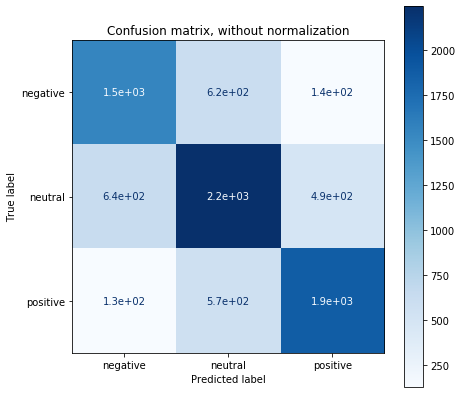

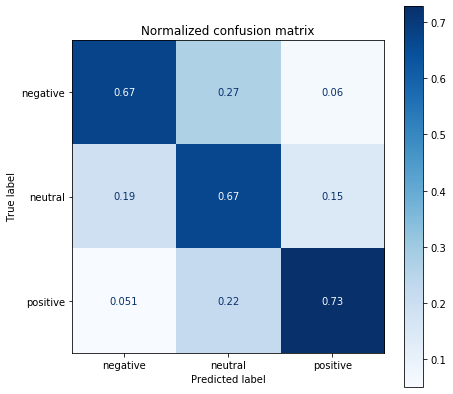

In [254]:
# Confusion Matrix of Classifier
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_best, X_test, y_test,
                                 display_labels=list(le.classes_),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches((7,7))

    print(title)
    print(disp.confusion_matrix)

plt.show()

Use the trained model to get the probability of each calss for each word in the vectorizer

### Post Processing

In [255]:
words = np.array(vectorizer.get_feature_names())

In [256]:
words.shape

(26439,)

In [257]:
X_train_full.shape[1]

26439

In [258]:
x = np.eye(words.shape[0])

In [259]:
clf_predict_proba = clf_best.predict_proba(x)
# clf_predict_proba[:,1]

In [260]:
np.shape(predicted_proba)

(26439, 3)

In [261]:
le.transform(["positive"])[0]

2

In [262]:
print ('The encoded labels corresponding to classes \n',le.classes_, 'are \n',le.transform(le.classes_))

The encoded labels corresponding to classes 
 ['negative' 'neutral' 'positive'] are 
 [0 1 2]


In [263]:
probs_dict = {}
for sent in le.classes_:

    probs_dict[sent+'_probs'] = clf_predict_proba[:, le.transform([sent])[0]]
    ind = np.argsort(probs_dict[sent+'_probs'])
    # Get good and bad words
    good_words = words[ind[-5:]]
    bad_words = words[ind[:5]]
    # Get corresponding probabilities
    good_prob = probs_dict[sent+'_probs'][ind[-5:]]
    bad_prob = probs_dict[sent+'_probs'][ind[:5]]
    
    # Print Best and Worst predictive words
    print("Good words\t     P(%s | word)" %sent)
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(p))
    
    print("Bad words\t     P(%s | word)" %sent)
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(p))

Good words	     P(negative | word)
                fail 0.96
               sucks 0.97
                miss 0.98
              stupid 0.98
                 sad 0.99
Bad words	     P(negative | word)
                love 0.00
              thanks 0.00
             awesome 0.00
                glad 0.00
               thank 0.00
Good words	     P(neutral | word)
             airport 0.87
             opinion 0.87
                jump 0.87
                  ed 0.87
                gots 0.89
Bad words	     P(neutral | word)
                love 0.00
               happy 0.00
              thanks 0.00
                good 0.01
                nice 0.01
Good words	     P(positive | word)
               great 0.99
                nice 0.99
               happy 0.99
              thanks 1.00
                love 1.00
Bad words	     P(positive | word)
                 sad 0.00
               sorry 0.00
                miss 0.00
              missed 0.00
                hate 0.00


Next for each tweet, we will try to look at the word with highest probability in a particular sentiment